In [28]:
import pandas as pd
import pickle,os, copy
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys


import re

from sklearn.cluster import DBSCAN


from deep_generalizability.nets import Nets
from deep_generalizability.utils import *
from deep_generalizability.postprocessing.postprocessing import *
from deep_generalizability.postprocessing.stats_plotting import *
from deep_generalizability.save_load import *

from deep_generalizability.postprocessing.sharpness_measures import *
from deep_generalizability.postprocessing.stats_plotting import *
from deep_generalizability.postprocessing.correlation import *


from deep_generalizability.data_getters import *

%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (13,9)

COLORS = plt.cm.tab20(np.arange(20))

CORRECT_COLOR_IDX = 3
INCORRECT_COLOR_IDX = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# add random data to data_getter
# Put a model in a folder. Maybe train for 0 steps. or train on random data. 
# we should now be able to use everything simply.

# Try to test our stuff on more complicated models. VGG or AlexNet. The pretrained ones for now? 

In [281]:
root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
data_name = "CIFAR10"
exp = "Large_Single_LeNet_cross-entropy copy"
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp)

In [282]:
load_cached_data(experiment_folder, "acc", step=-1)

(None, None)

In [271]:
stats_df = get_end_stats(experiment_folder, step=-1)


In [272]:
stats_df.sort_values(by="Acc Test Mean", ascending=False)

Loss Test Mean  Loss Train Mean  Acc Train Mean  \
1600718589.2489228        0.072841         0.000021             1.0   
1600718589.249843         0.094470         0.000034             1.0   

                    Acc Test Mean  Acc Gap Mean  Norm Mean batch_train_size  
1600718589.2489228         0.9834       -0.0166          0              256  
1600718589.249843          0.9794       -0.0206          0             4096

In [283]:
margin_filters = get_exp_margins(experiment_folder, softmax_outputs=False, step=10001, seed=0, device=None, num_datapoints=50000, on_test_set=False, should_cache=False)


Files already downloaded and verified
Files already downloaded and verified
8.624228239059448


In [286]:
10 * 500 / 60 

83.33333333333333

In [265]:
point_traces, meta = load_cached_data(experiment_folder, "point_traces", step=10001)

In [266]:
linear_loss_trace_filters = get_exp_linear_loss_trace(experiment_folder, step=10001, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)


In [267]:
margin_filters.keys()

dict_keys(['1600718589.2489228', '1600718589.249843'])

/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misin

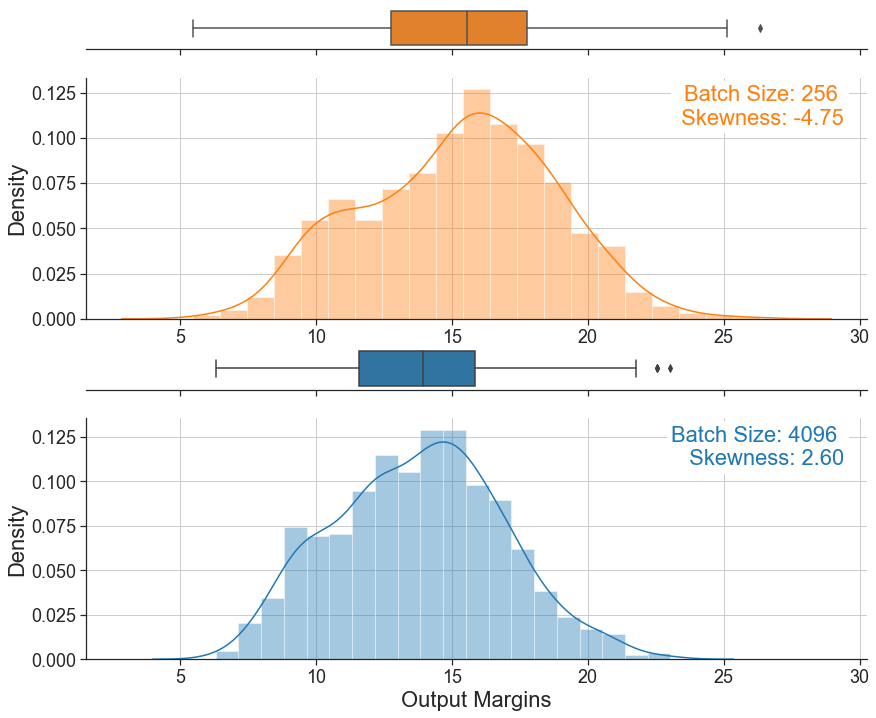

In [280]:
import seaborn as sns


sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]

x1 = margin_filters["1600718589.2489228"]['0'][0]
x2 = margin_filters["1600718589.249843"]['0'][0] # np.random.randn(100)

skewness1 = scipy.stats.moment(x1, moment=3)
skewness2 = scipy.stats.moment(x2, moment=3)

f, (ax1_box, ax1_hist, ax2_box, ax2_hist) = plt.subplots(4, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85, .15, .85)}, figsize=(14,12))

sns.boxplot(x1, ax=ax1_box, color=c1)
sns.distplot(x1, ax=ax1_hist, color=c1)

sns.boxplot(x2, ax=ax2_box, color=c2)
sns.distplot(x2, ax=ax2_hist, color=c2)

ax1_box.set(yticks=[])
ax2_box.set(yticks=[])
ax1_hist.tick_params(axis='both', labelbottom=True, labelsize=18)
ax2_hist.tick_params(axis='both', labelbottom=True, labelsize=18)

ax2_hist.set_xlabel("Output Margins", fontsize=22)
ax1_hist.set_ylabel(ylabel="Density", fontsize=22)
ax2_hist.set_ylabel(ylabel="Density", fontsize=22)



sns.despine(ax=ax1_hist)
sns.despine(ax=ax1_box, left=True)

sns.despine(ax=ax2_hist)
sns.despine(ax=ax2_box, left=True)

ax1_hist.text(x=0.97, y=0.97, transform=ax1_hist.transAxes, s="Batch Size: 256 \n Skewness: {:.2f}".format(skewness1) ,\
         fontsize=22, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color=c1)

ax2_hist.text(x=0.97, y=0.97, transform=ax2_hist.transAxes, s="Batch Size: 4096 \n Skewness: {:.2f}".format(skewness2) ,\
         fontsize=22, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color=c2)

ax1_hist.grid(b=True, which='major')
ax2_hist.grid(b=True, which='major')


f.savefig("./best_thing_ever", dpi=300, bbox_inches = "tight",)

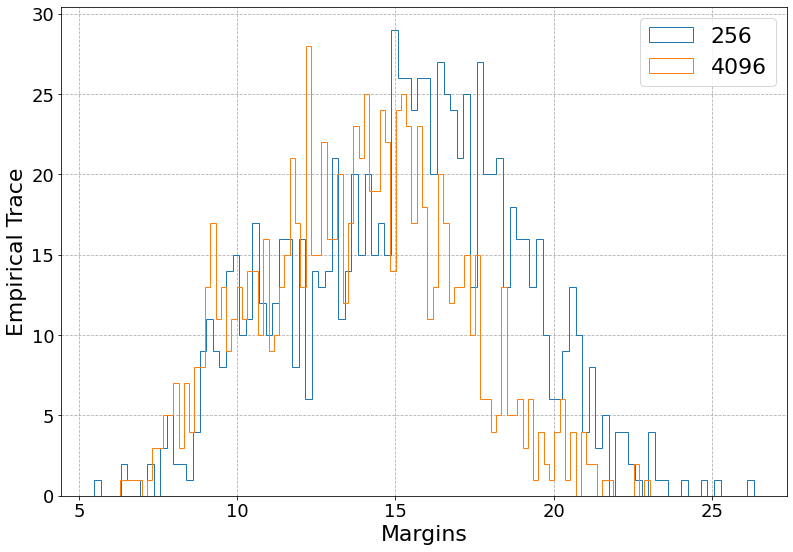

In [69]:
# histogram 

# Plot margins box
# X_axis_name = "Margins"
# Y_axis_name = "Empirical Trace"


plot_name = "Correct_Incorrect"
X_axis_bounds = None #[0.99, 1.0001]
Y_axis_bounds = None

save_exp_path = experiment_folder

filter_seperate = None # ["batch_train_size"]
filter_not_seperate = ["batch_train_size"]

pre_filtered_exp_ids = None

use_correct_filter = False
draw_correlation = False # True

data_func = margins_correct_incorrect_hist_plot(margin_filters, use_correct_filter=use_correct_filter)

hp_data_func_plot(experiment_folder, data_func, X_axis_name, Y_axis_name, 
                  plot_name, filter_seperate, filter_not_seperate,
                 save_exp_path, X_axis_bounds, Y_axis_bounds, 
                    pre_filtered_exp_ids)


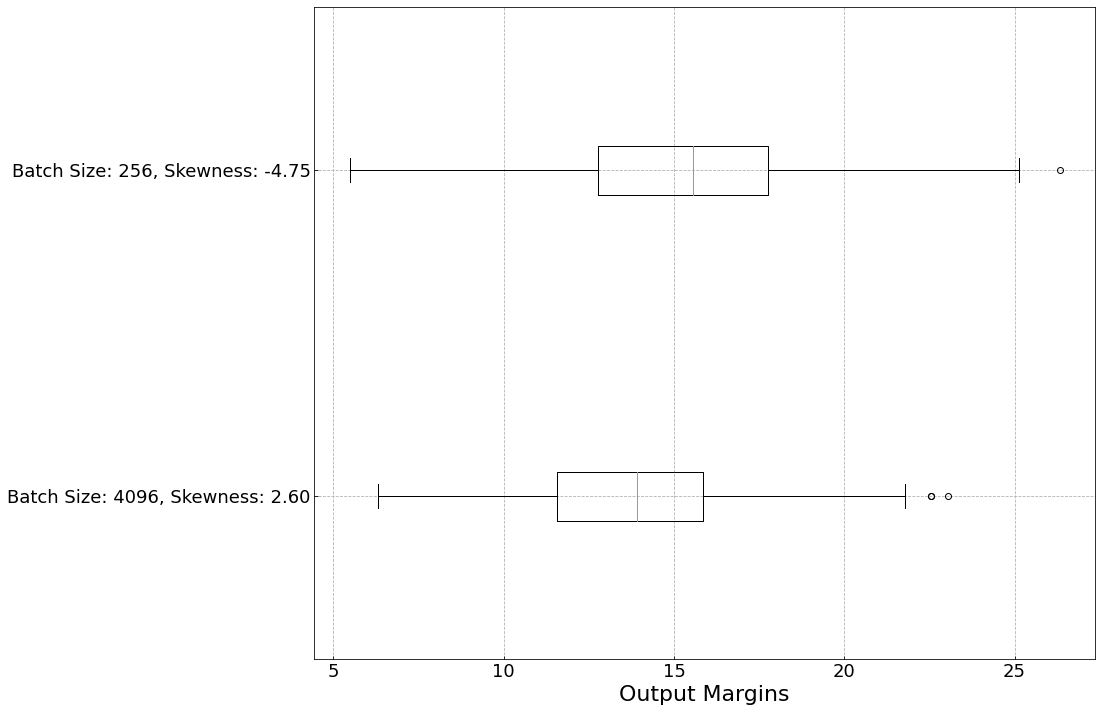

In [243]:
# histogram 

# Plot margins box
# X_axis_name = "Margins"
Y_axis_name = ""


plot_name = "Box_Plot"
X_axis_bounds = None # [0.99, 1.0001]
Y_axis_bounds = None

save_exp_path = experiment_folder

filter_seperate = None # ["batch_train_size"]
filter_not_seperate = ["batch_train_size"]

pre_filtered_exp_ids = None

use_correct_filter = False
draw_correlation = False # True

data_func = margins_correct_incorrect_box_plot(margin_filters, use_correct_filter=use_correct_filter)

hp_data_func_plot(experiment_folder, data_func, X_axis_name, Y_axis_name, 
                  plot_name, filter_seperate, filter_not_seperate,
                 save_exp_path, X_axis_bounds, Y_axis_bounds, 
                    pre_filtered_exp_ids)


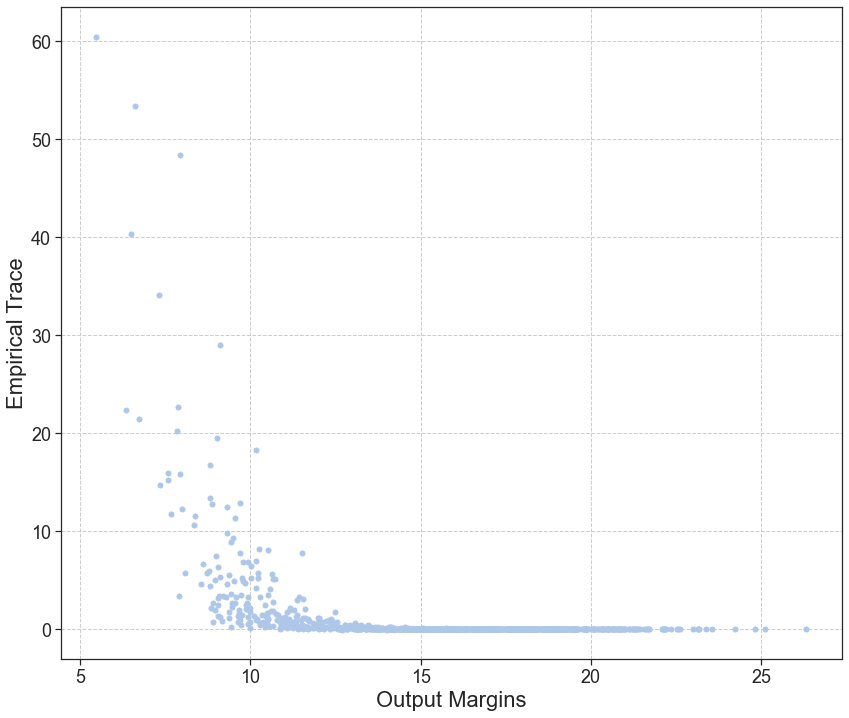

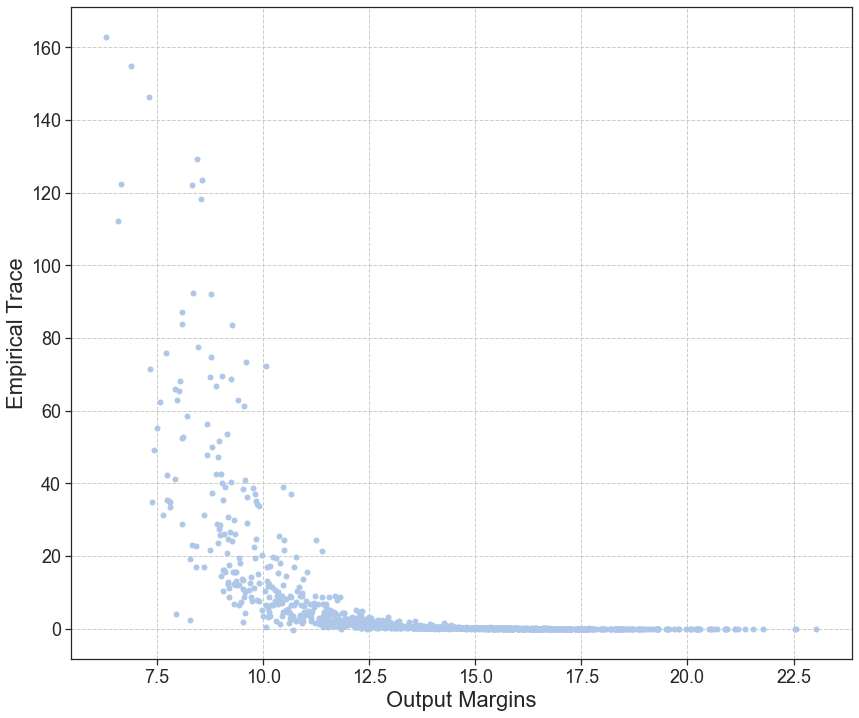

In [232]:

# Plot trace vs margins
X_axis_name = "Output Margins"
Y_axis_name = "Empirical Trace"


plot_name = "all"
X_axis_bounds = None #[0, 50] #[0.99, 1.0001]
Y_axis_bounds = None #[0, 200]

save_exp_path = experiment_folder

filter_seperate = ["batch_train_size"]
filter_not_seperate = None

pre_filtered_exp_ids = None

use_correct_filter = False
draw_correlation = False # True 

data_func = margin_trace_correct_incorrect_plot(margin_filters, point_traces, use_correct_filter=use_correct_filter, draw_correlation=draw_correlation)

hp_data_func_plot(experiment_folder, data_func, X_axis_name, Y_axis_name, 
                  plot_name, filter_seperate, filter_not_seperate,
                 save_exp_path, X_axis_bounds, Y_axis_bounds, 
                    pre_filtered_exp_ids)



In [153]:
all_steps = get_exp_steps(experiment_folder)
all_steps = np.array([list(v.keys()) for v in all_steps.values()]).reshape(-1)
all_steps = sorted(list(set(all_steps)))

# Plot trace vs margins
X_axis_name = "ACEHT"
Y_axis_name = "Empirical Trace"


plot_name = "C_IC"
X_axis_bounds = None #[0, 1.001]
Y_axis_bounds = None #[0, 200]


filter_seperate = None # ["batch_train_size"]
filter_not_seperate = None

pre_filtered_exp_ids = None

use_correct_filter = True
draw_correlation = True



0
{'1599422110.2201154': {'0': (0.1062, 0.0934)}}
Files already downloaded and verified
Files already downloaded and verified
-7.656457238501551


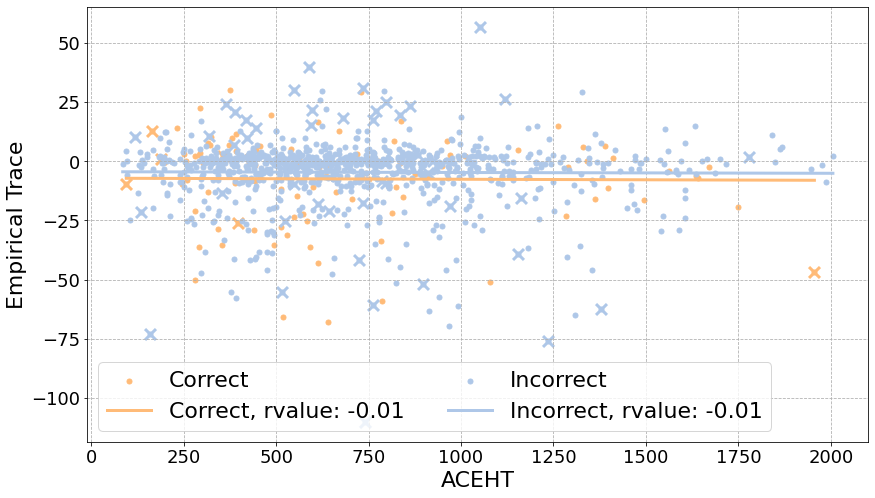

1
{'1599422110.2201154': {'0': (0.106, 0.0926)}}
Files already downloaded and verified
Files already downloaded and verified
-7.944721485371928


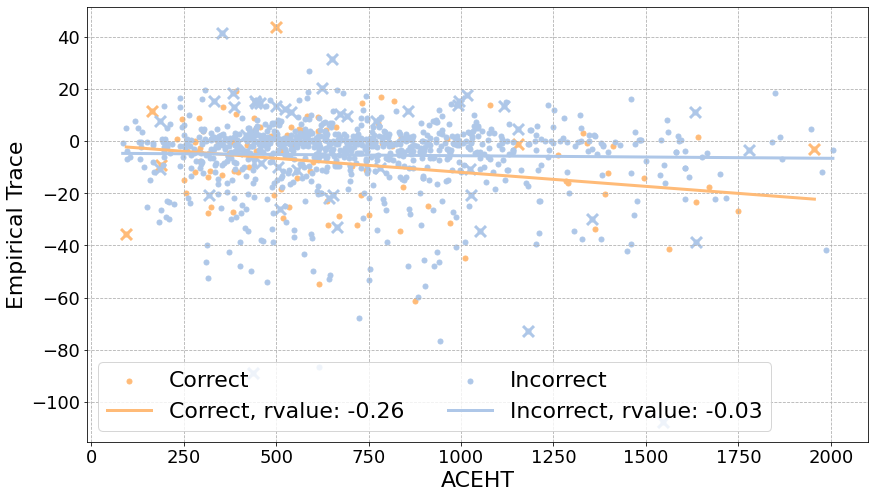

251
{'1599422110.2201154': {'0': (0.2632, 0.263)}}
Files already downloaded and verified
Files already downloaded and verified
13.766714438388824


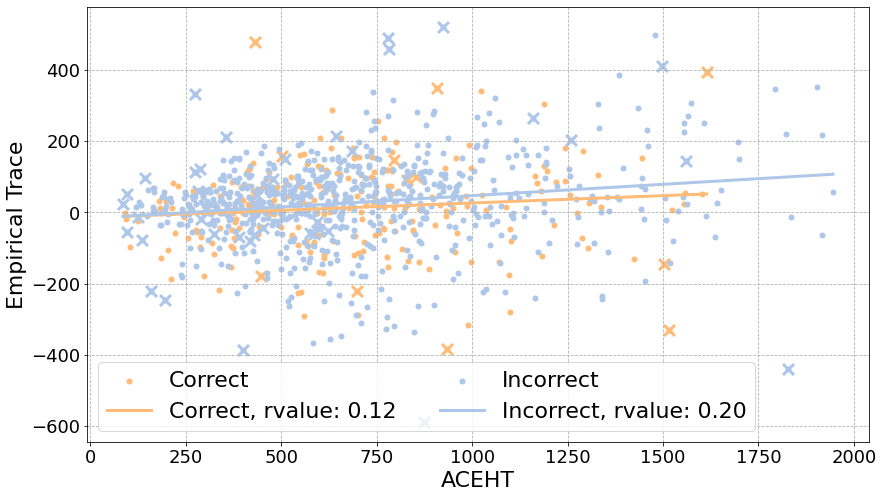

501
{'1599422110.2201154': {'0': (0.3602, 0.3658)}}
Files already downloaded and verified
Files already downloaded and verified
62.38680911817439


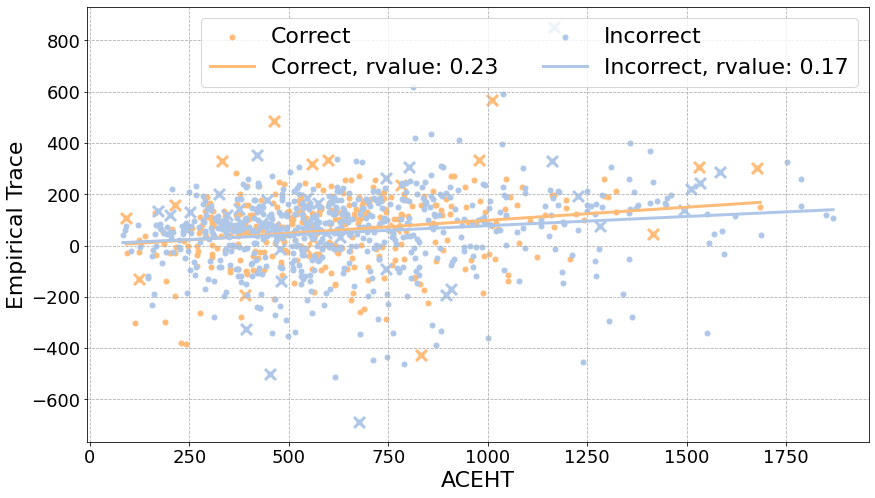

751
{'1599422110.2201154': {'0': (0.429, 0.4292)}}
Files already downloaded and verified
Files already downloaded and verified
154.2754100645441


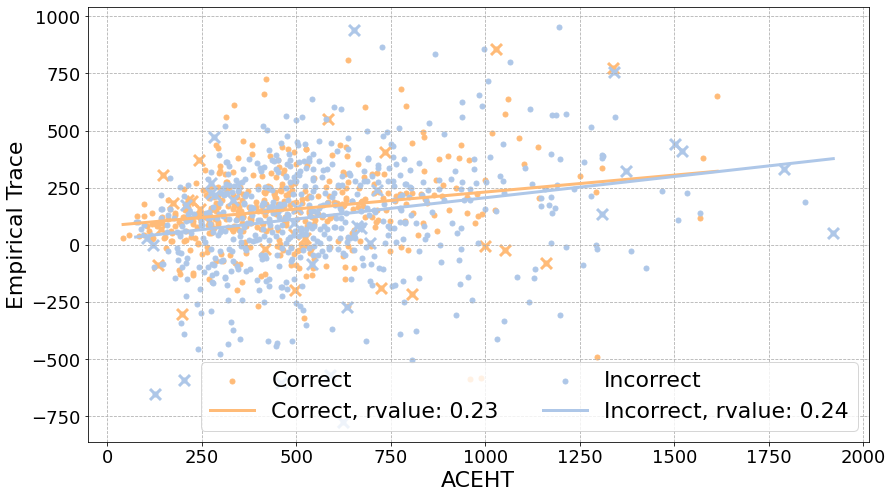

1001
{'1599422110.2201154': {'0': (0.4082, 0.4012)}}
Files already downloaded and verified
Files already downloaded and verified
179.19530796919753


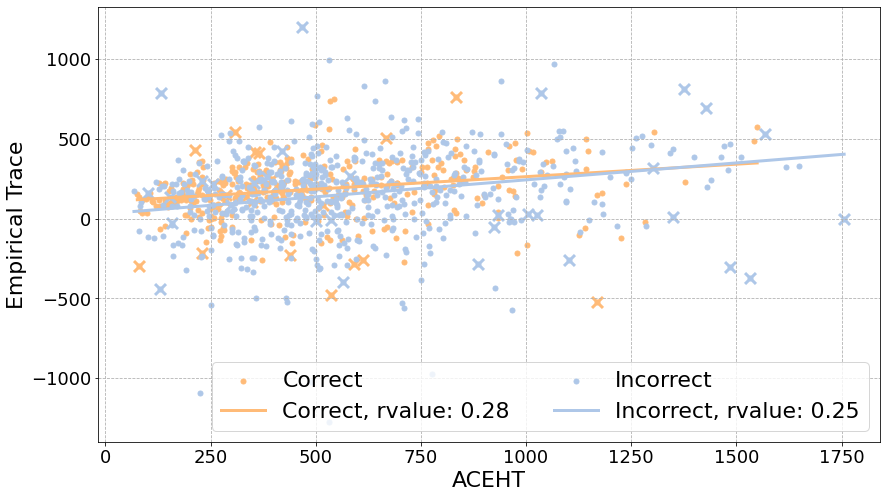

1251
{'1599422110.2201154': {'0': (0.4804, 0.4494)}}
Files already downloaded and verified
Files already downloaded and verified
280.8712367378253


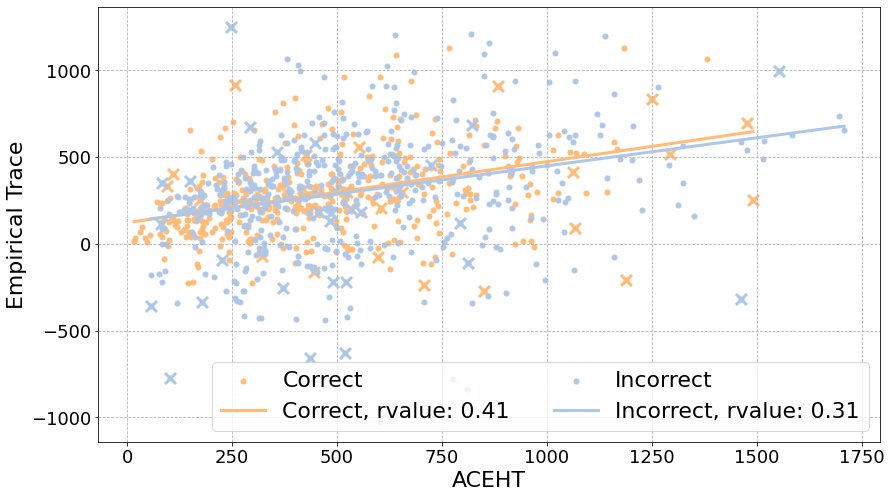

1501
{'1599422110.2201154': {'0': (0.5794, 0.5424)}}
Files already downloaded and verified
Files already downloaded and verified
306.23349866300924


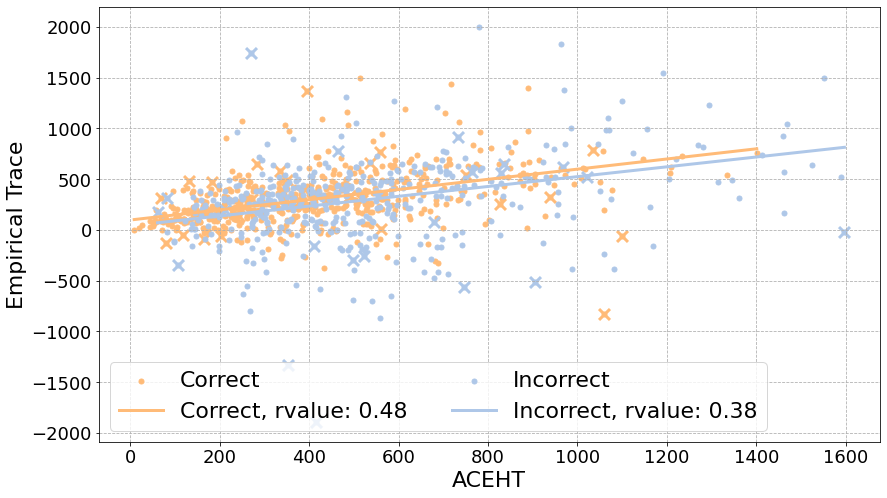

1751
{'1599422110.2201154': {'0': (0.551, 0.508)}}
Files already downloaded and verified
Files already downloaded and verified
326.57667980320605


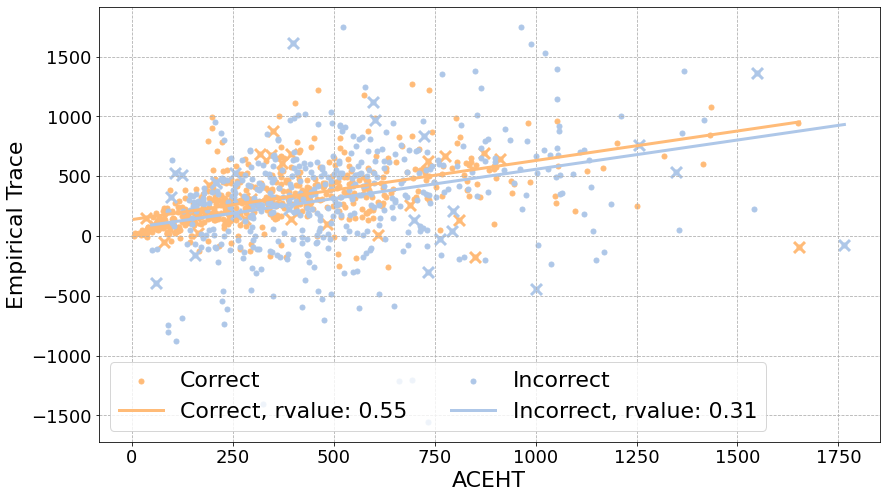

2001
{'1599422110.2201154': {'0': (0.6326, 0.5728)}}
Files already downloaded and verified
Files already downloaded and verified
396.4543949006064


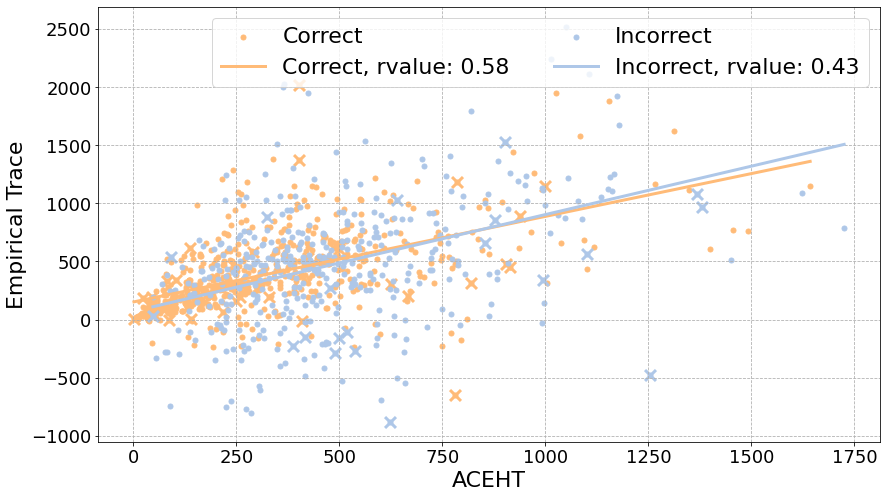

2251
{'1599422110.2201154': {'0': (0.6076, 0.5294)}}
Files already downloaded and verified
Files already downloaded and verified
457.3837906622213


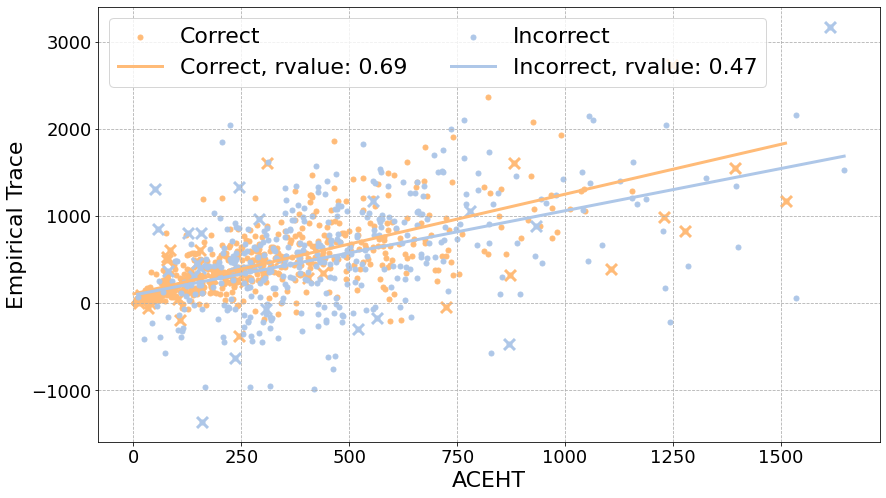

2501
{'1599422110.2201154': {'0': (0.691, 0.5808)}}
Files already downloaded and verified
Files already downloaded and verified
457.6341026606401


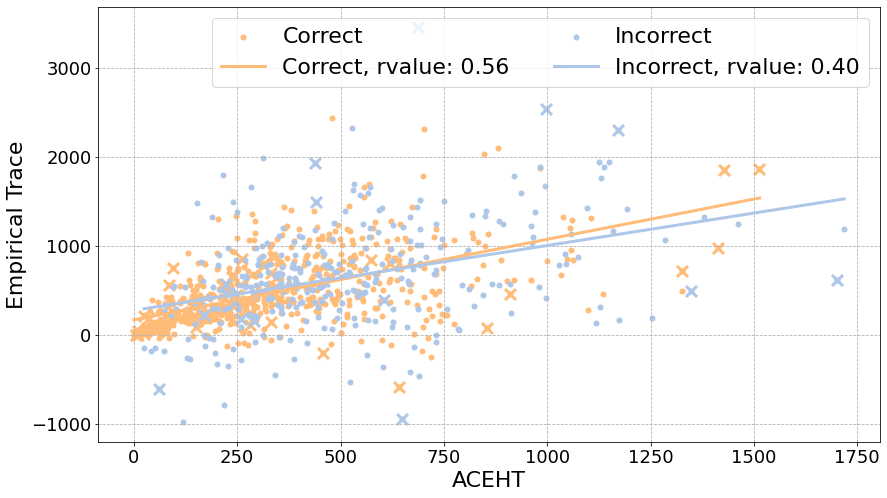

2751
{'1599422110.2201154': {'0': (0.6924, 0.5708)}}
Files already downloaded and verified
Files already downloaded and verified
531.2336322382279


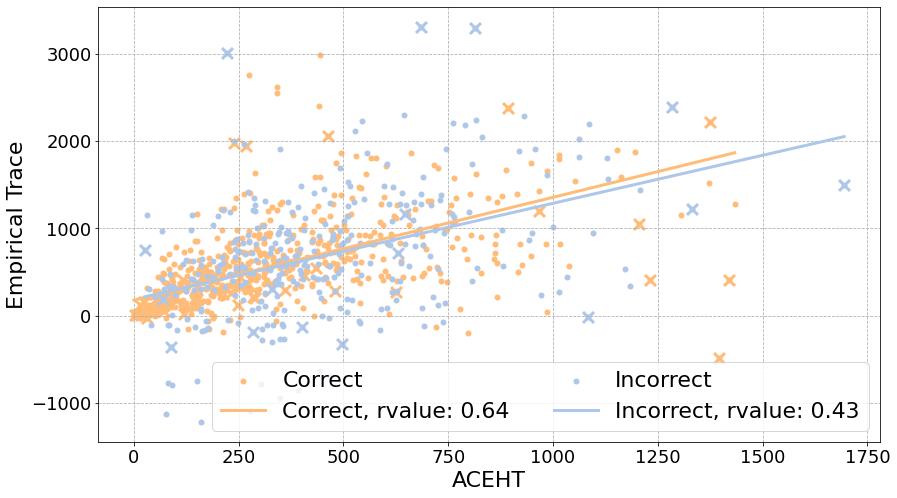

3001
{'1599422110.2201154': {'0': (0.7256, 0.587)}}
Files already downloaded and verified
Files already downloaded and verified
655.1782389221165


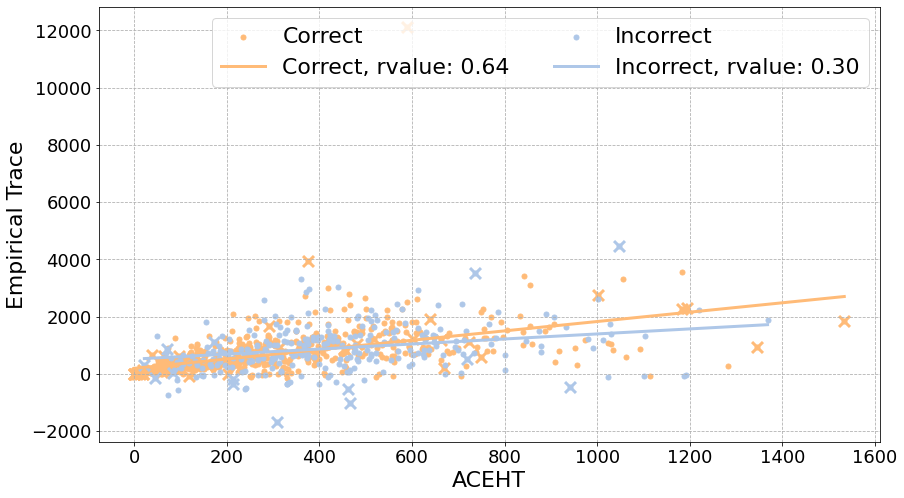

3251
{'1599422110.2201154': {'0': (0.7364, 0.578)}}
Files already downloaded and verified
Files already downloaded and verified
639.21913405667


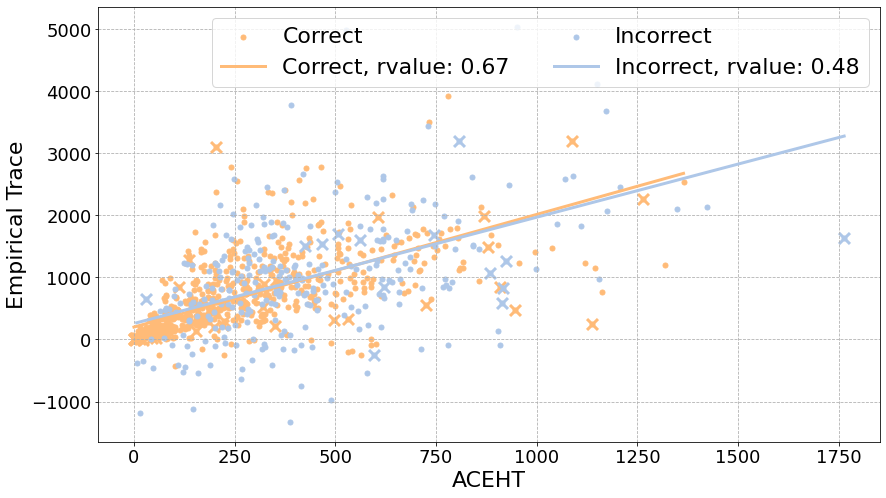

3501
{'1599422110.2201154': {'0': (0.754, 0.5674)}}
Files already downloaded and verified
Files already downloaded and verified
704.8556831394643


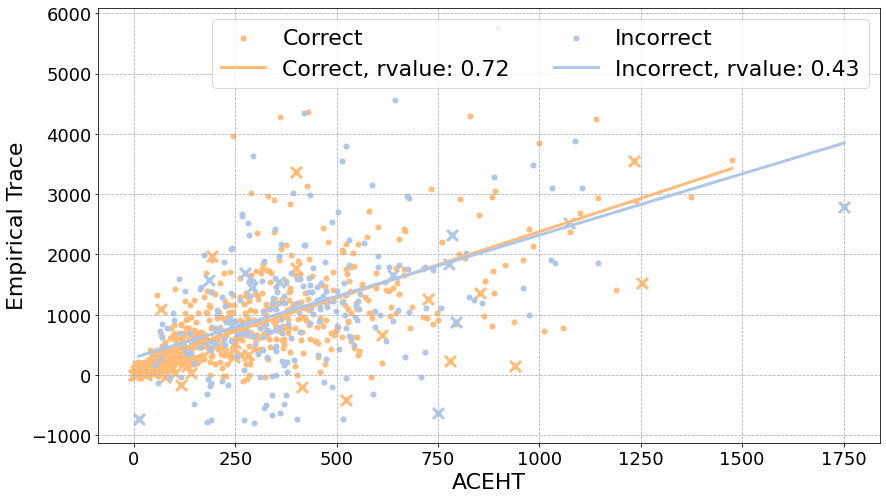

3751
{'1599422110.2201154': {'0': (0.7734, 0.5694)}}
Files already downloaded and verified
Files already downloaded and verified
761.2300483101529


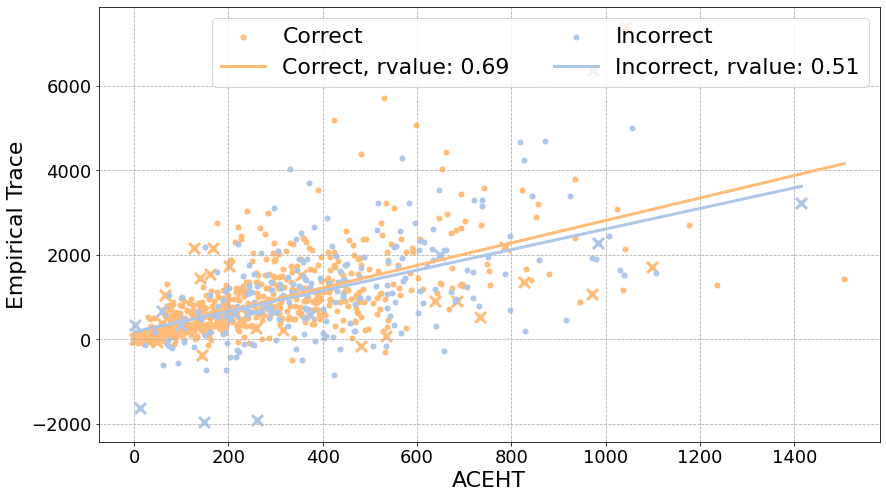

4001
{'1599422110.2201154': {'0': (0.8174, 0.5738)}}
Files already downloaded and verified
Files already downloaded and verified
831.5820669469693


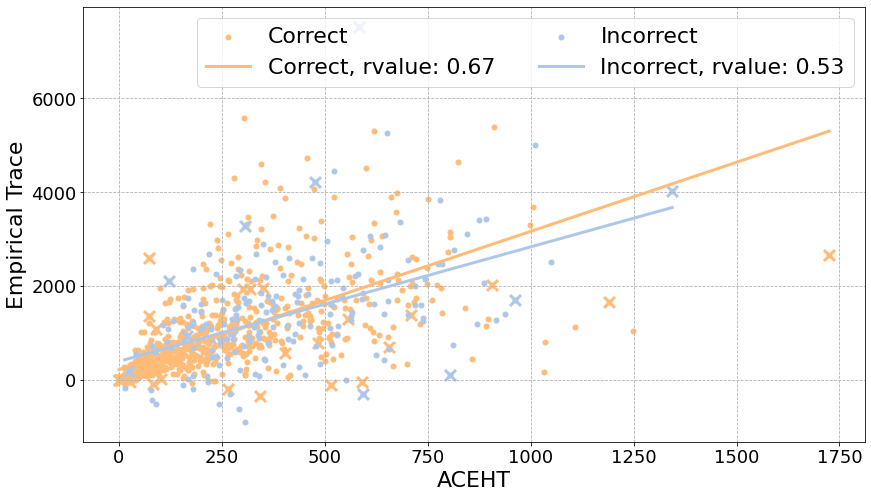

4251
{'1599422110.2201154': {'0': (0.7282, 0.5254)}}
Files already downloaded and verified
Files already downloaded and verified
887.2271927633329


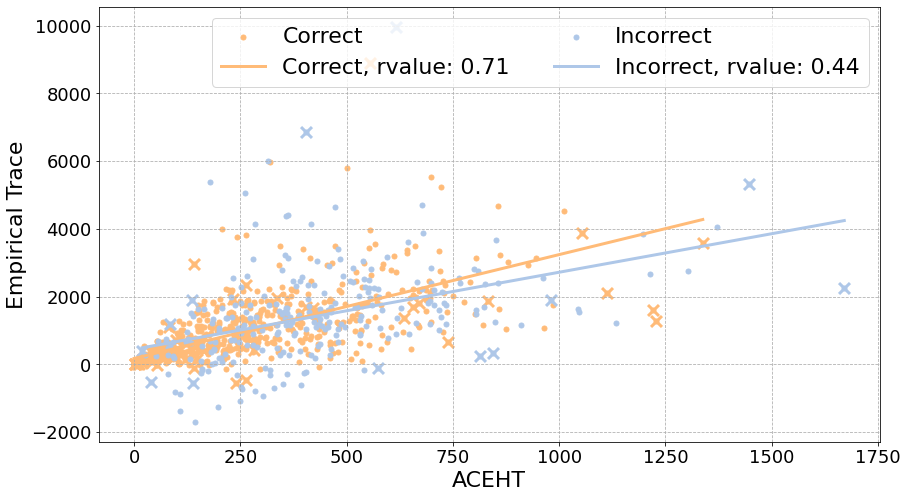

4501
{'1599422110.2201154': {'0': (0.8356, 0.5702)}}
Files already downloaded and verified
Files already downloaded and verified
893.0150959032622


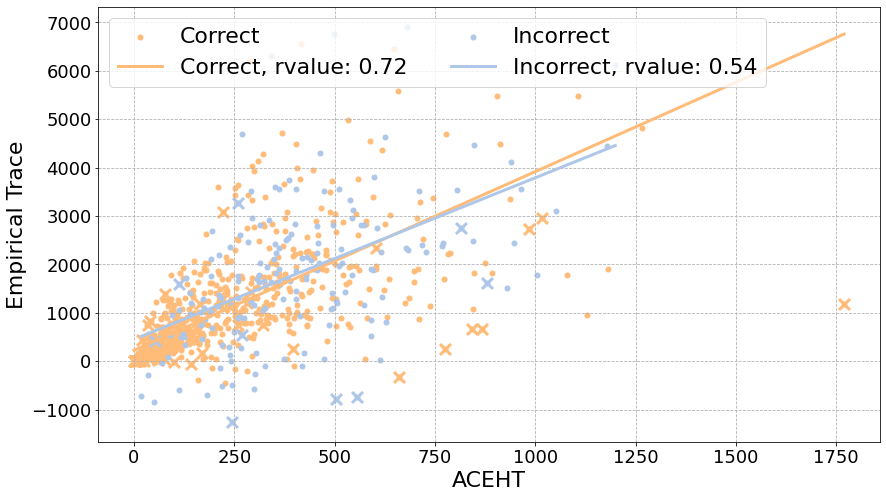

4751
{'1599422110.2201154': {'0': (0.8484, 0.5692)}}
Files already downloaded and verified
Files already downloaded and verified
820.9612955124901


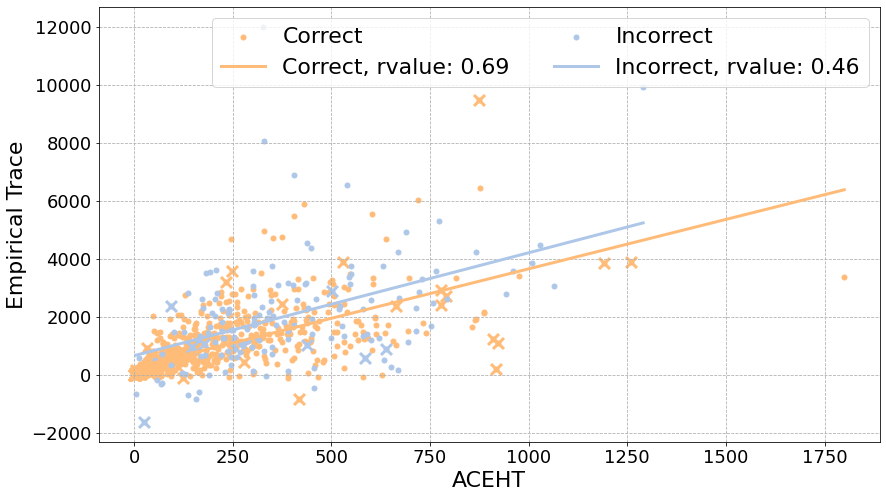

5001
{'1599422110.2201154': {'0': (0.8118, 0.549)}}
Files already downloaded and verified
Files already downloaded and verified
892.8851522606277


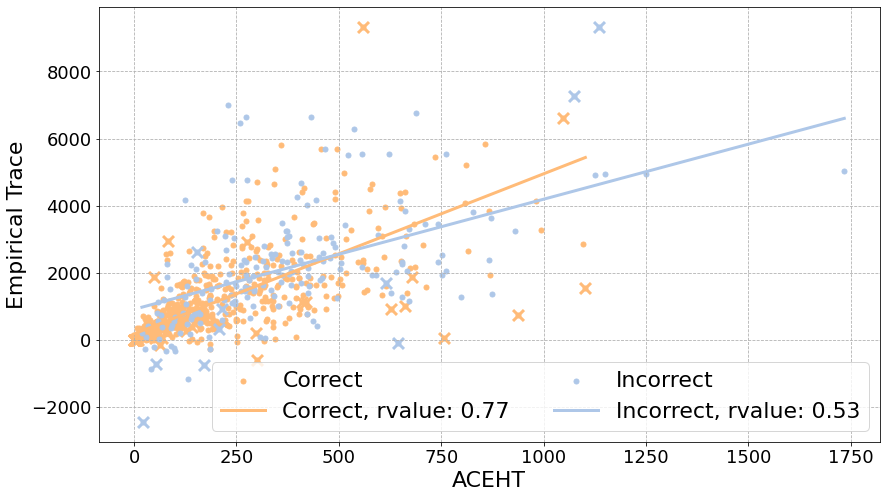

5251
{'1599422110.2201154': {'0': (0.8876, 0.5732)}}
Files already downloaded and verified
Files already downloaded and verified
826.01445007473


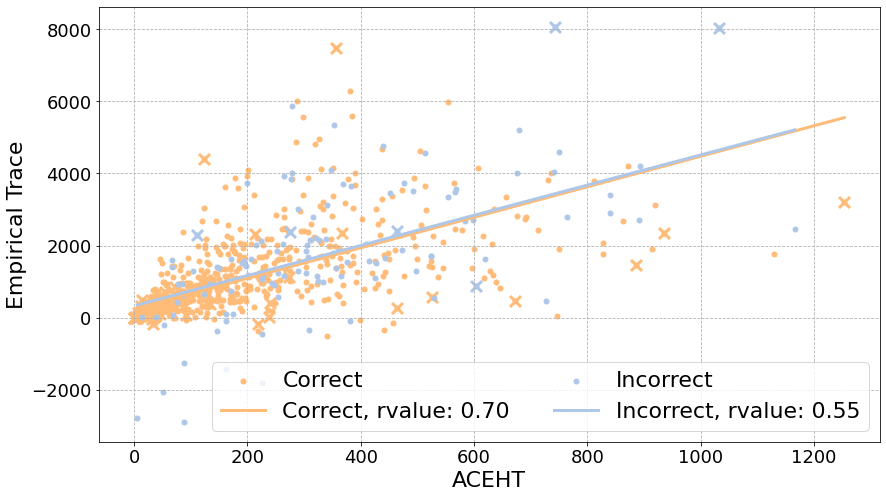

5501
{'1599422110.2201154': {'0': (0.8878, 0.5678)}}
Files already downloaded and verified
Files already downloaded and verified
889.962894490216


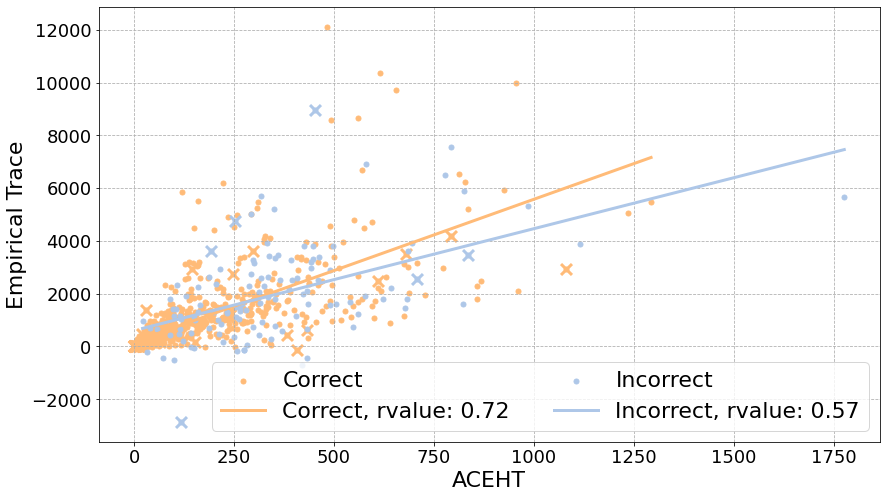

5751
{'1599422110.2201154': {'0': (0.7462, 0.5182)}}
Files already downloaded and verified
Files already downloaded and verified
1001.4037814481129


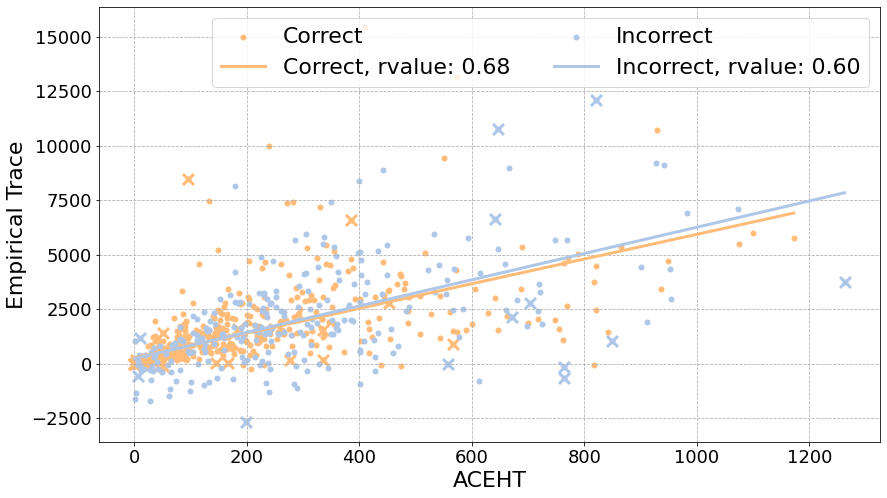

6001
{'1599422110.2201154': {'0': (0.8876, 0.5568)}}
Files already downloaded and verified
Files already downloaded and verified
981.0000981225328


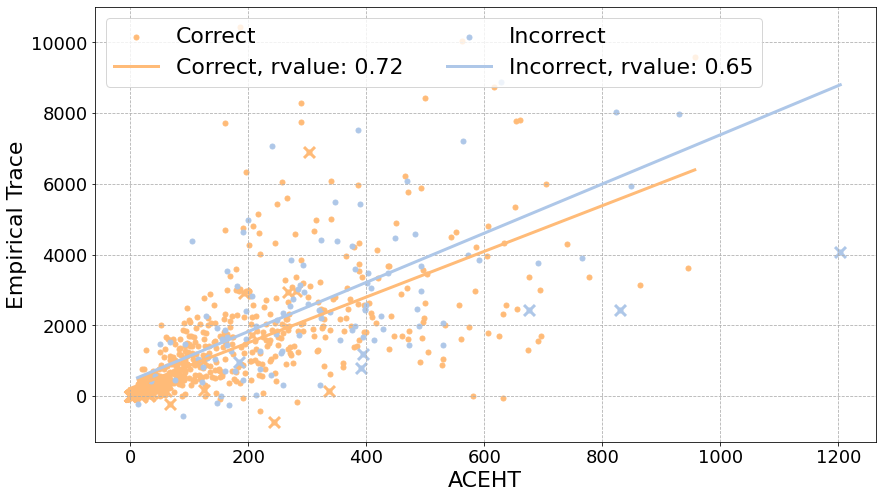

6251
{'1599422110.2201154': {'0': (0.8796, 0.545)}}
Files already downloaded and verified
Files already downloaded and verified
1102.6798459677243


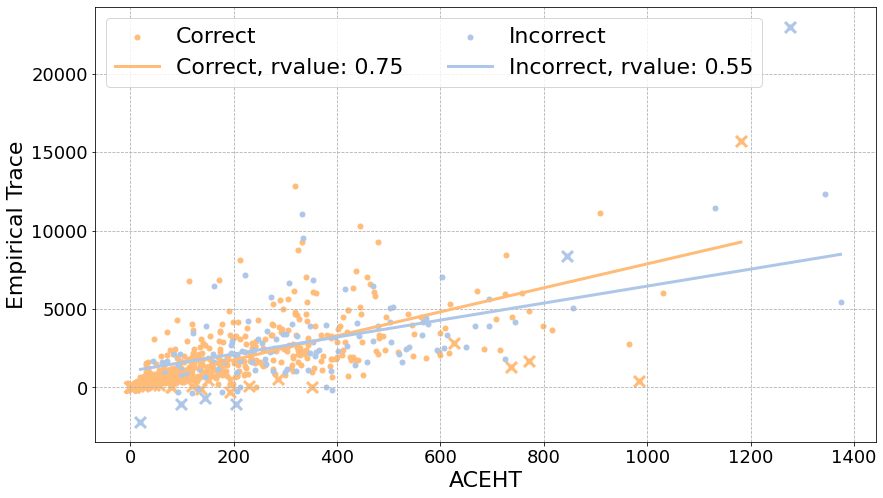

6501
{'1599422110.2201154': {'0': (0.902, 0.5556)}}
Files already downloaded and verified
Files already downloaded and verified
1015.339336295558


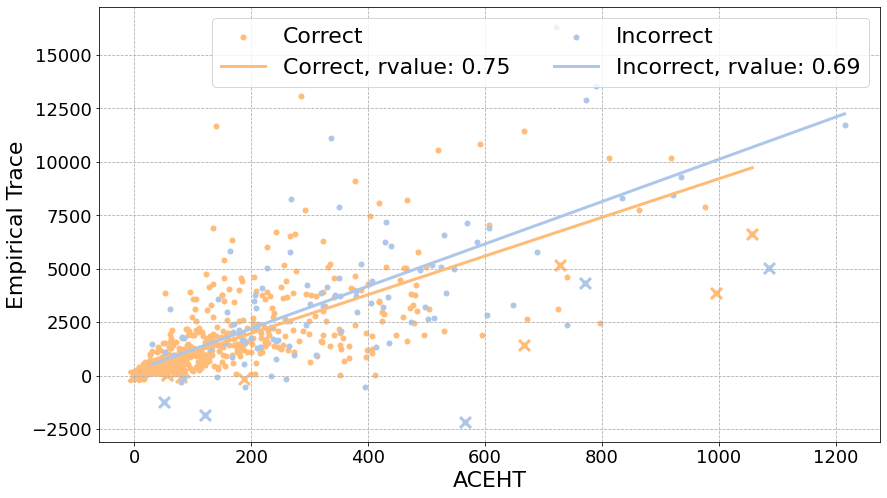

6751
{'1599422110.2201154': {'0': (0.919, 0.5592)}}
Files already downloaded and verified
Files already downloaded and verified
973.1616091234736


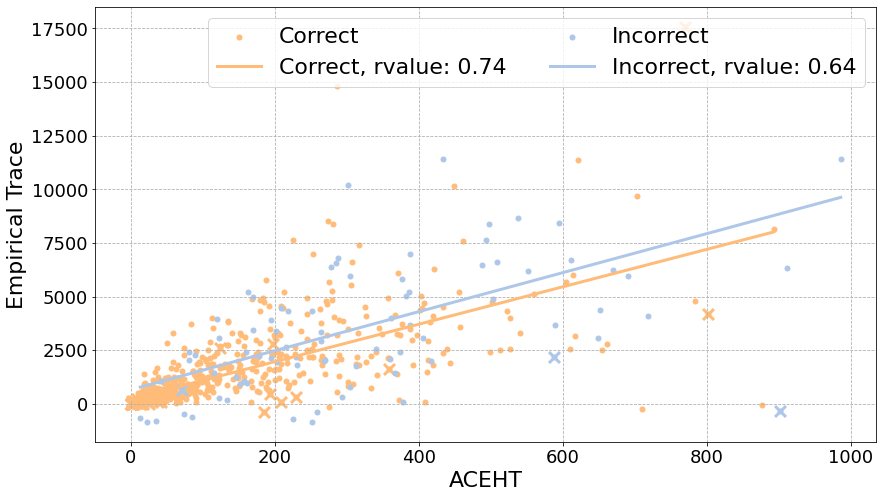

7001
{'1599422110.2201154': {'0': (0.9258, 0.5516)}}
Files already downloaded and verified
Files already downloaded and verified
942.1736453943971


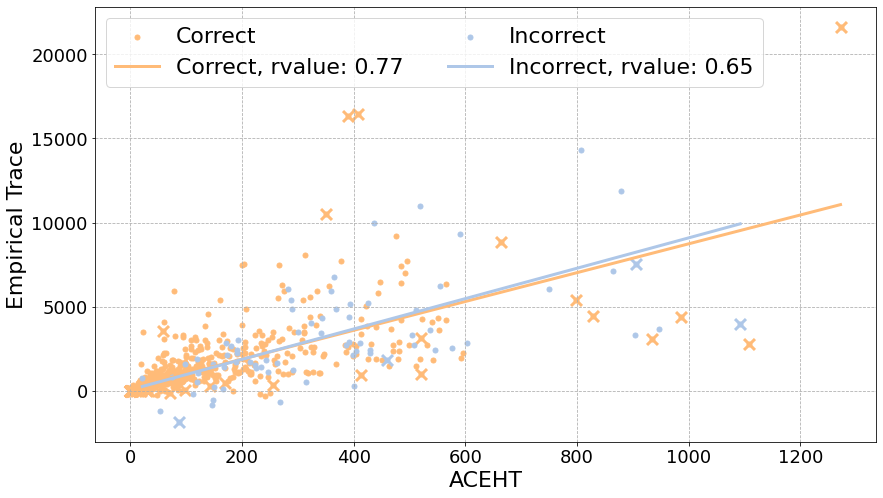

7251
{'1599422110.2201154': {'0': (0.9102, 0.5504)}}
Files already downloaded and verified
Files already downloaded and verified
1026.3278473886355


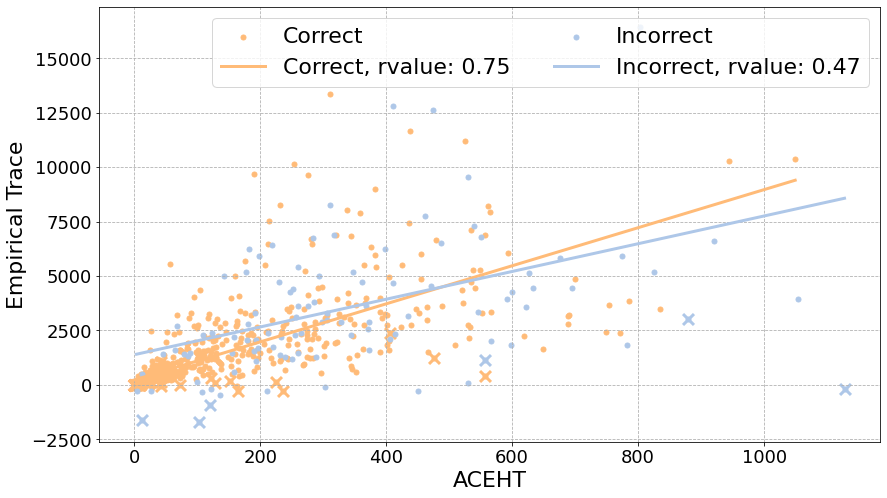

7501
{'1599422110.2201154': {'0': (0.9416, 0.5592)}}
Files already downloaded and verified
Files already downloaded and verified
878.2091073418295


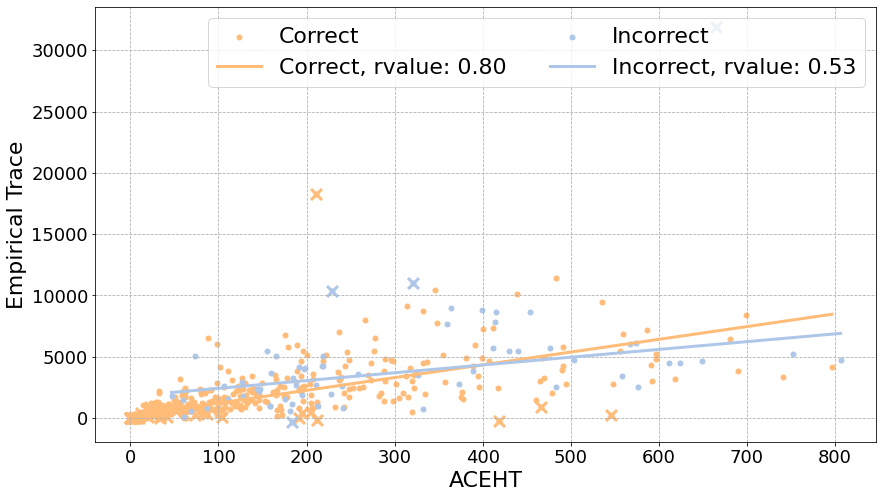

7751
{'1599422110.2201154': {'0': (0.9434, 0.5538)}}
Files already downloaded and verified
Files already downloaded and verified
943.307207900849


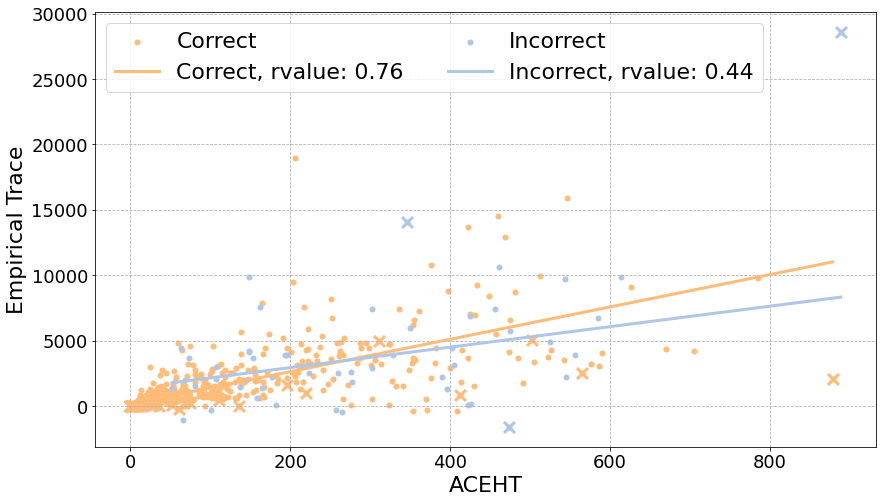

8001
{'1599422110.2201154': {'0': (0.9358, 0.547)}}
Files already downloaded and verified
Files already downloaded and verified
871.9721212877181


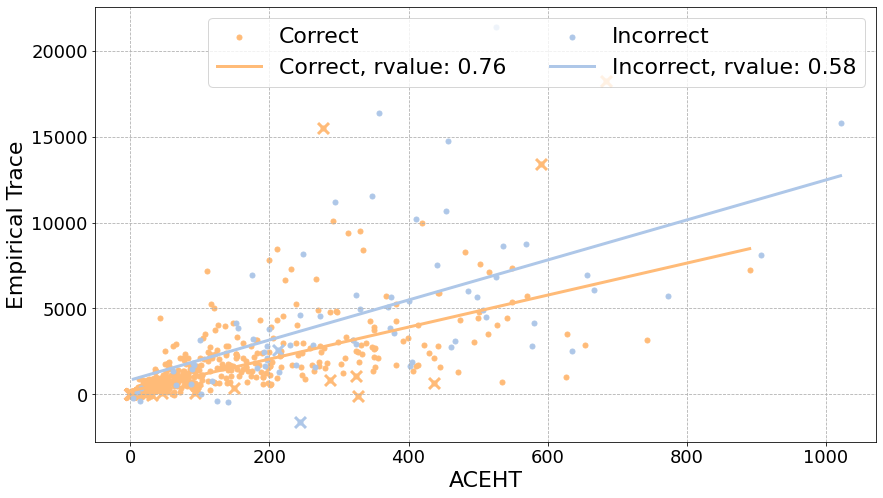

8251
{'1599422110.2201154': {'0': (0.9696, 0.5618)}}
Files already downloaded and verified
Files already downloaded and verified
764.5024960691572


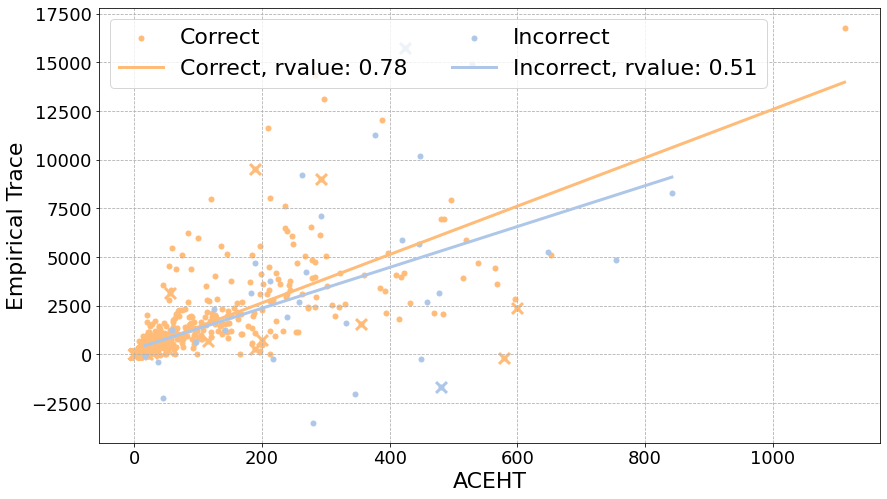

8501
{'1599422110.2201154': {'0': (0.9618, 0.5576)}}
Files already downloaded and verified
Files already downloaded and verified
887.8094170582929


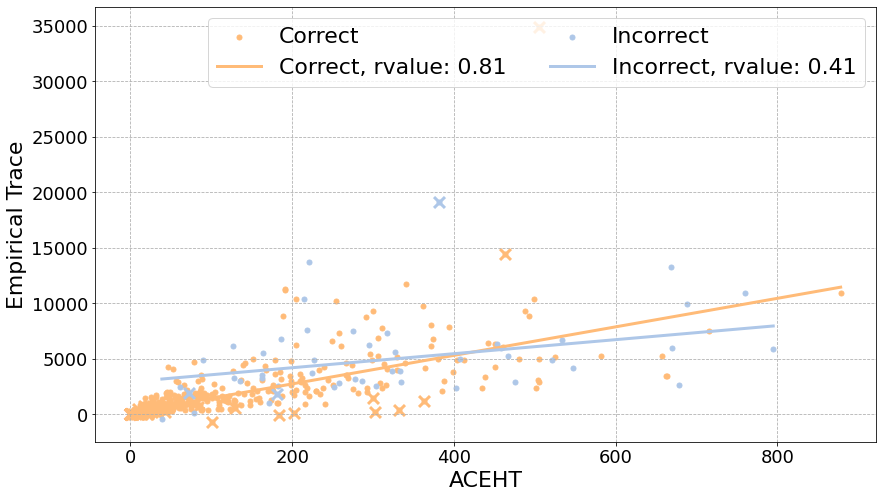

8751
{'1599422110.2201154': {'0': (0.9686, 0.556)}}
Files already downloaded and verified
Files already downloaded and verified
734.0627938109784


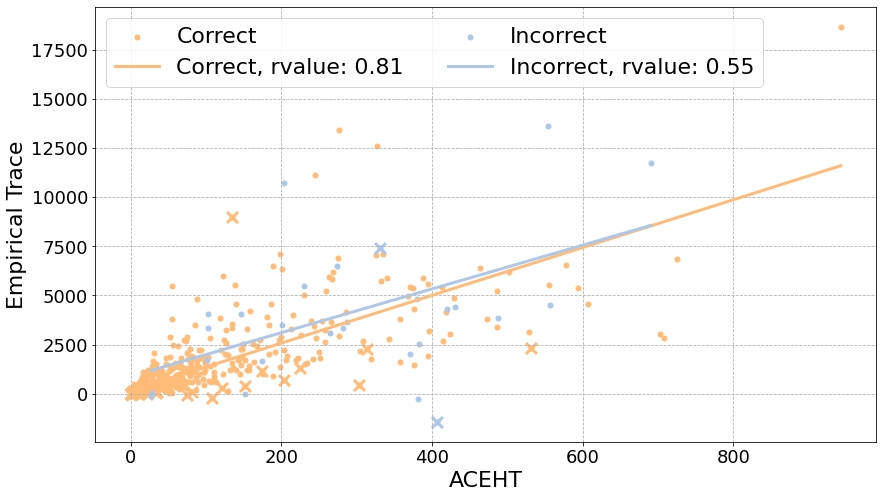

9001
{'1599422110.2201154': {'0': (0.8014, 0.499)}}
Files already downloaded and verified
Files already downloaded and verified
1255.9030794656915


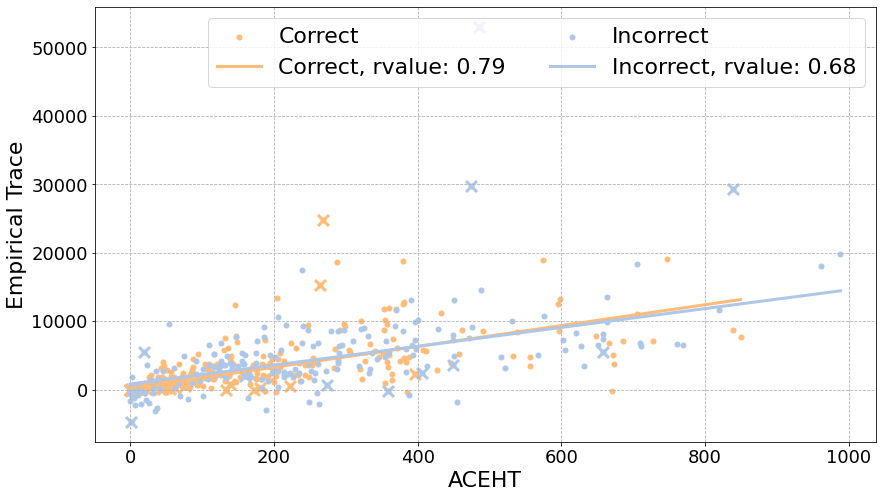

9251
{'1599422110.2201154': {'0': (0.9748, 0.5518)}}
Files already downloaded and verified
Files already downloaded and verified
713.542109639689


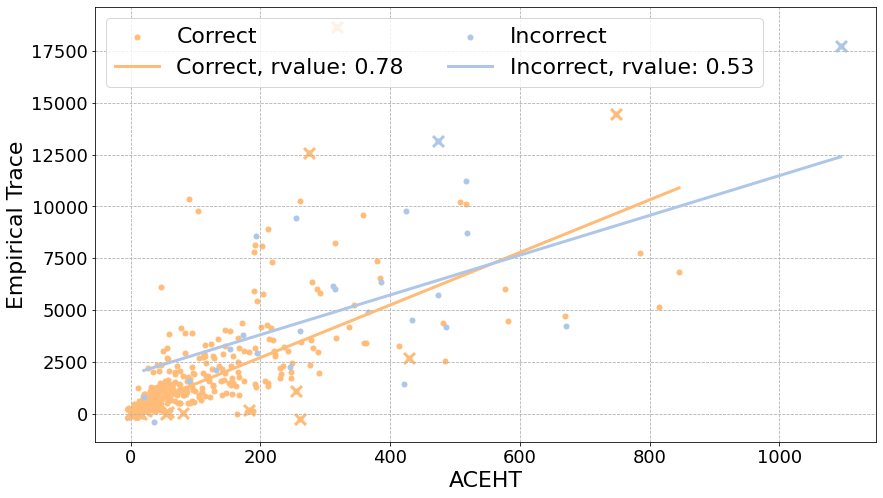

9501
{'1599422110.2201154': {'0': (0.9744, 0.5542)}}
Files already downloaded and verified
Files already downloaded and verified
761.3058380678135


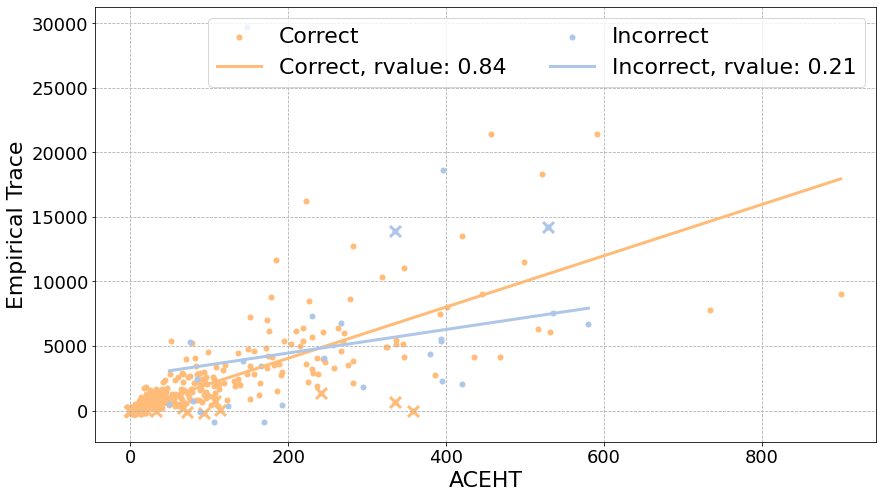

9751
{'1599422110.2201154': {'0': (0.99, 0.5534)}}
Files already downloaded and verified
Files already downloaded and verified
686.5360547638437


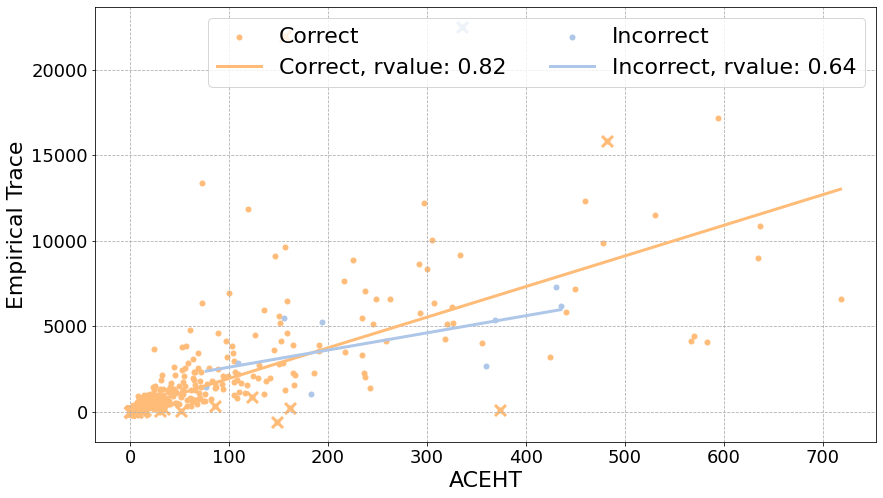

10001
{'1599422110.2201154': {'0': (0.7898, 0.494)}}
Files already downloaded and verified
Files already downloaded and verified
1299.9053131687228


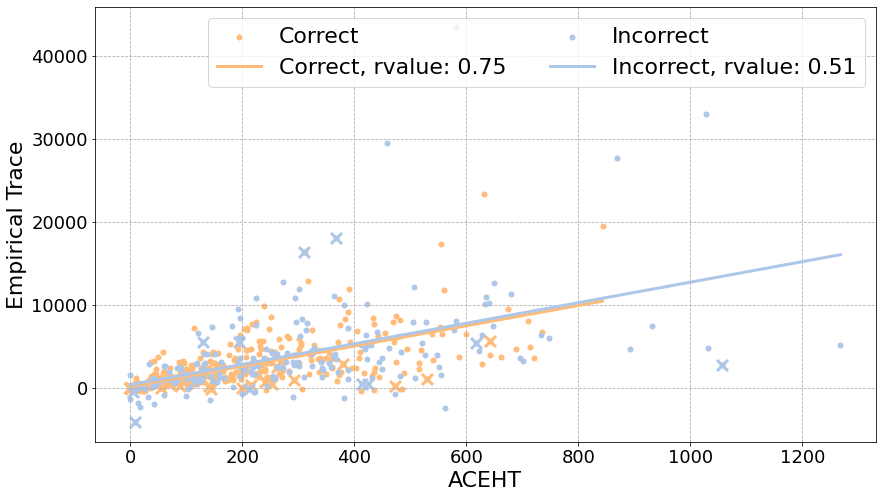

In [154]:
save_time_path = os.path.join(experiment_folder, "time_corr")
if not os.path.isdir(save_time_path):
    os.mkdir(save_time_path)

for step in all_steps:
    print(step)
    acc, _ = load_cached_data(experiment_folder, "acc", step=step)
    print(acc)
    
    curr_point_traces, meta = load_cached_data(experiment_folder, "point_traces", step=step)
    linear_loss_trace_filters = get_exp_linear_loss_trace(experiment_folder, step=step, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)
#     linear_loss_trace_filters = get_exp_margins(experiment_folder, softmax_outputs=True, step=step, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)
    
    curr_plot_name = "{}_step_{}".format(plot_name, step)
    
    data_func = margin_trace_correct_incorrect_plot(linear_loss_trace_filters, curr_point_traces, use_correct_filter=use_correct_filter, draw_correlation=draw_correlation)
    
    hp_data_func_plot(experiment_folder, data_func, X_axis_name, Y_axis_name, 
                      curr_plot_name, filter_seperate, filter_not_seperate,
                 save_time_path, X_axis_bounds, Y_axis_bounds, 
                    pre_filtered_exp_ids)



In [287]:
root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
data_name = "CIFAR10"
exp = "Large_Single_LeNet_cross-entropy copy"
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp)


X_data_filter_f = lambda step: get_exp_linear_loss_trace(experiment_folder, step=step, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)

# X_data_filter_f = lambda step: get_exp_margins(experiment_folder, get_upperbound=True, softmax_outputs=True, step=step, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False) # get_exp_linear_loss_trace(experiment_folder, step=step, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)

Y_data_f = lambda step:  load_cached_data(experiment_folder, "point_traces", step=step)[0]
use_correct_filter = True
c = get_corr_array(experiment_folder, X_data_filter_f, Y_data_f, use_correct_filter)


0
Files already downloaded and verified
Files already downloaded and verified
-0.00044724007706120427
1
Files already downloaded and verified
Files already downloaded and verified
-0.010754001949524528
251
Files already downloaded and verified
Files already downloaded and verified
0.041071228926265566
501
Files already downloaded and verified
Files already downloaded and verified
0.102075920064355
751
Files already downloaded and verified
Files already downloaded and verified
0.1480453599718397
1001
Files already downloaded and verified
Files already downloaded and verified
0.15647458218206772
1251
Files already downloaded and verified
Files already downloaded and verified
0.3518767257086955
1501
Files already downloaded and verified
Files already downloaded and verified
0.5009479662887171
1751
Files already downloaded and verified
Files already downloaded and verified
0.4939443824277982
2001
Files already downloaded and verified
Files already downloaded and verified
0.7366587423732143

In [156]:
a = c["1599422110.2201154"]["0"]

/Users/daniellengyel/deep_generalizability/deep_generalizability/postprocessing/stats_plotting.py:120: UserWarning:

Legend does not support [<matplotlib.lines.Line2D object at 0x7f94c25731c0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists

/Users/daniellengyel/deep_generalizability/deep_generalizability/postprocessing/stats_plotting.py:120: UserWarning:

Legend does not support [<matplotlib.lines.Line2D object at 0x7f94c25733a0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists



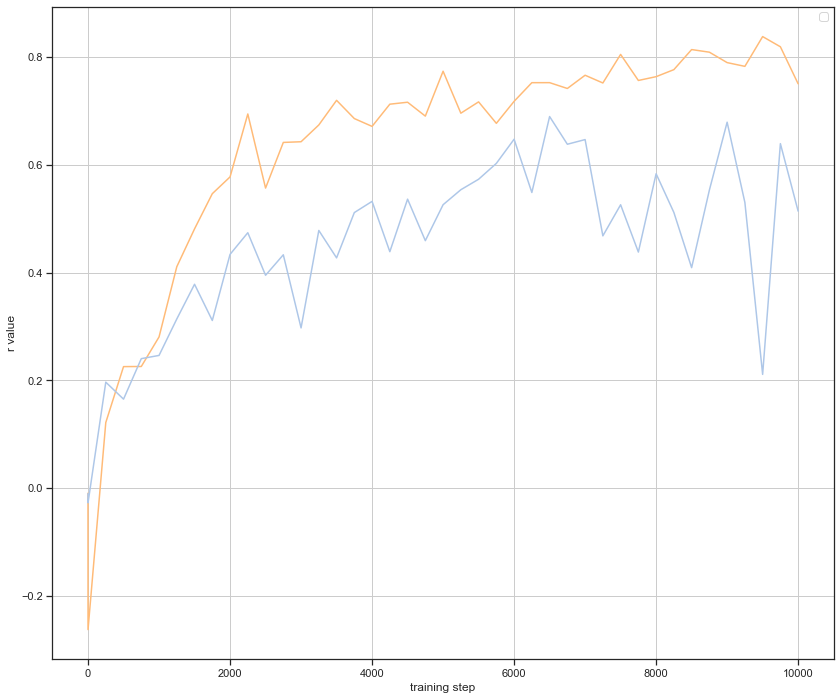

In [288]:
for exp_id in c:
    a = c[exp_id]["0"]

    plots = []
    plots_names = []
    X_axis_name = "training step"
    Y_axis_name = "r value"

    save_location = os.path.join(experiment_folder, "time_r_ACEHT")


    plots.append(plt.plot(list(a["correct_r_value"].keys()), list(a["correct_r_value"].values()), label="Correctly Predicted", color=COLORS[CORRECT_COLOR_IDX]))
    plots.append(plt.plot(list(a["incorrect_r_value"].keys()), list(a["incorrect_r_value"].values()), label="Incorrectly Predicted",  color=COLORS[INCORRECT_COLOR_IDX]))
#     plots_names = ["Correctly Predicted", "Incorrectly Predicted"] 

    
    costum_plot(plots, plots_names, X_axis_name, Y_axis_name, X_axis_bounds=None, Y_axis_bounds=None, save_location=save_location)



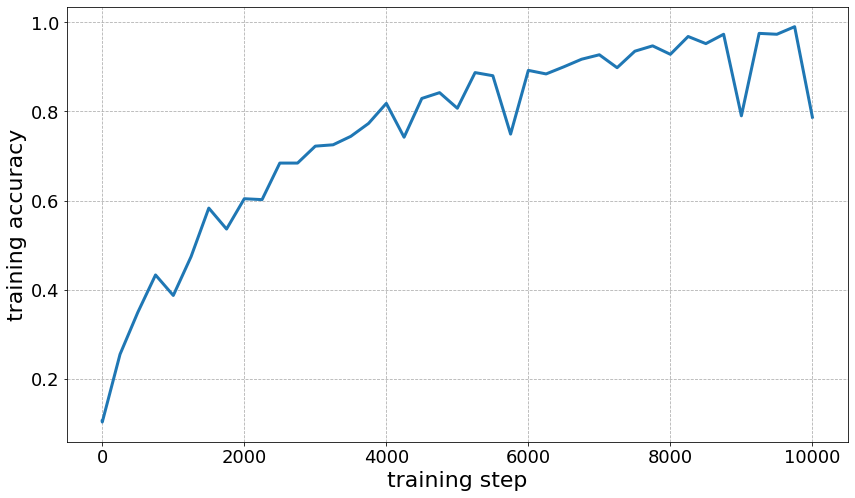

In [158]:
plots = []
plots_names = []
X_axis_name = "training step"
Y_axis_name = "training accuracy"

save_location = os.path.join(experiment_folder, "time_acc")


plots.append(plt.plot(list(a["acc"].keys()), list(a["acc"].values())))

costum_plot(plots, plots_names, X_axis_name, Y_axis_name, X_axis_bounds=None, Y_axis_bounds=None, save_location=save_location)

